In [209]:
import warnings
import pandas 
pandas.set_option('mode.use_inf_as_na', True)

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# This is required to catch warnings when the multiprocessing module is used
import os

os.environ["PYTHONWARNINGS"] = "ignore"
# import pertpy as pt
import scanpy as sc

import pertpy as pt
# adata = pt.dt.kang_2018()
from torch import tensor
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from collections import defaultdict
rowGeneExpression2 = defaultdict(dict)
import math
criterion = torch.nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
one ='DatlingerBock2017.h5ad'

folders = '/home/awahab/llm-testing/data_sets/'

adata = sc.read_h5ad(folders + one)


In [212]:
len(hv_columns), len(normal_genes)

(4642, 36722)

In [213]:
from fastai.data.transforms import RandomSplitter
from collections import defaultdict

#def h5adToData(adata):
rowGeneExpression = defaultdict(int)

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
#     sc.experimental.pp.recipe_pearson_residuals(adata)

sc.pp.pca(adata)
hv_genes = (list(adata.var[adata.var['highly_variable'] == True].index))
normal_genes = (list(adata.var_names))

hv_columns = [i for i,val in enumerate(normal_genes)
              if val in hv_genes
             ]

df = adata.obs
end = 50 if True else -1
#     for column in hv_columns:
#         for row_id in range(math.floor(float(df.shape[0])))[:end]:
#             rowGeneExpression[row_id] += adata.X[row_id, column]

from scipy.sparse import csr_matrix, find


found = find(adata.X)

sums = []

rowGeneExpression = defaultdict(int)
rows, columns, vals = found
hvc = set(hv_columns)
#convert hv_columns to set
row_id = 0
for val in range(len(rows)):
    row_id = rows[val]
    column = columns[val]
    rowGeneExpression[row_id] += vals[val]


#df = adata.obs
#df2 = pd.get_dummies(df, columns=[])
#df2.columns

dependent_variables = list(df['perturbation'].map(lambda val: 0 if val == 'control' else 1).values)
#[rowGeneExpression[row] for row in range(df.shape[0])]
#print(rowGeneExpression.values())
#df['geneExpressionCount'] = rowGeneExpression.values()
#df['geneExpressionCount'] = df[df['perturbed'] !== 'ctrl'].map(lambda x: 1 if x == 'ctrl' else 0)

# how to spedcially weight columns 

numerical_values = df.select_dtypes(include=[int, float]).values.tolist()

# for row,val in enumerate(numerical_values):
#     numerical_values[row] = numerical_values[row] + list(adata.obsm['X_pca'][row])
#dependent_variables = [x for x in dependent_variables]

t_dep = tensor(dependent_variables) # pertrubations
t_indep = tensor(numerical_values, dtype=torch.float)

independent_variables = pd.DataFrame(numerical_values)
vals,indices = t_indep.max(dim=0)
vals += .01
t_indep = t_indep / vals
#t_indep = t_indep / vals

trn_split,val_split=RandomSplitter(seed=42)(independent_variables)

trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
    
#     return t_dep,t_indep, trn_dep, trn_indep ,val_dep, val_indep, df

#t_dep,t_indep, trn_dep, trn_indep ,val_dep, val_indep, df = h5adToData(adata)


In [214]:
indep_cols =  df.select_dtypes(include=[int, float]).columns.tolist()

In [215]:
indep_cols

['ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts']

In [216]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()
init_coeffs()

tensor([ 0.3676, -0.3518, -0.3007,  0.2006,  0.2746], requires_grad=True)

In [258]:
# optimizer = torch.optim.SGD(
#     model.parameters(), 
#     lr=learning_rate, 
#     weight_decay=lambda_param
# )

# loss_function = torch.nn.CrossEntropyLoss()

#def runNN(t_dep, t_indep, trn_dep,trn_indep ,val_dep, val_indep, df):

#dropout, svd, latent space
torch.manual_seed(443)
n_coeff = t_indep.shape[1]

def calc_preds(coeffs, indeps): return (coeffs * indeps).sum(axis=1)
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))
#def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
#def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()
x = torch.randn(2)
lossi  = []
acci = []

def softmax_activation(z):
    exponentials = torch.exp(z)
    exponentials_row_sums = torch.sum(exponentials, axis=1).unsqueeze(1)  # 1
    return exponentials / exponentials_row_sums

def update_coeffs(coeffs, lr): 
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()
    

def train_model(epochs, lr):
    coeffs = init_coeffs()
    for i in range(epochs):
        loss = calc_loss(coeffs, t_indep, t_dep)
        loss.backward()
        lossi.append(loss.log10().item())
        with torch.no_grad(): update_coeffs(coeffs, lr)
        acci.append(acc(coeffs))
        #print(show_coeffs())
    return coeffs

coeffs = train_model(30, lr=.02)
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.2)).float().mean()
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))

#len([prob for prob in calc_preds(coeffs, t_indep) if prob > .1]) # should be 5000
#print([prob for prob in calc_preds(coeffs, t_indep)])
print(len([prob for prob in calc_preds(coeffs, t_indep) if prob < .5]))

#make an option to be like 0 or 1

1475


In [243]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
sum([item.item() for item in show_coeffs().values()])

0.7222282588481903

In [244]:
calc_preds(coeffs, val_indep)

tensor([0.7159, 0.7476, 0.7089, 0.7037, 0.7156, 0.7098, 0.7132,  ..., 0.7065, 0.5864, 0.7106, 0.6953, 0.7095, 0.5773, 0.7083])

In [245]:
print(len([prob for prob in calc_preds(coeffs, t_indep) if prob > .87]))


0


In [246]:
len([prob for key, prob in enumerate(calc_preds(coeffs, t_indep)) if prob > .5 and dependent_variables[key] == 1])

4585

In [248]:
len([row for key,row in enumerate(dependent_variables) if rowGeneExpression[key] > mean  ])
#weight the genes
predictions = [prob for prob in calc_preds(coeffs, t_indep) ]
len(predictions)
print((len([var for var in dependent_variables if var]), len([var for var in dependent_variables if not var])))

(4585, 1320)


In [249]:
mean = sum(rowGeneExpression.values()) / len(rowGeneExpression)
mean

3030.9392704475945

In [250]:
#rowGeneExpression

In [251]:
#print(([prob for prob in calc_preds(coeffs, t_indep)]))

[tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900),
 tensor(0.7900

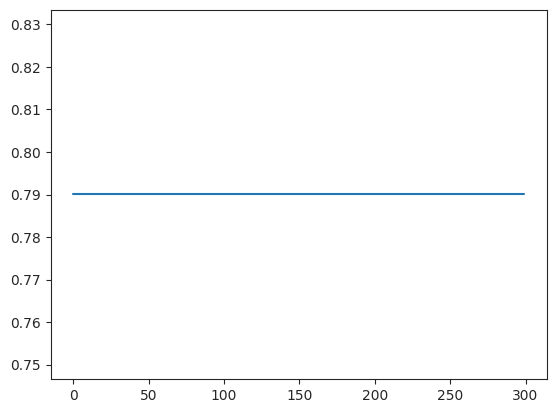

In [252]:

acci

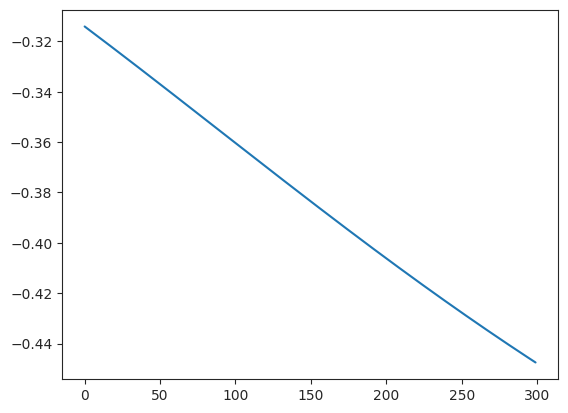

In [253]:
plt.plot(lossi)


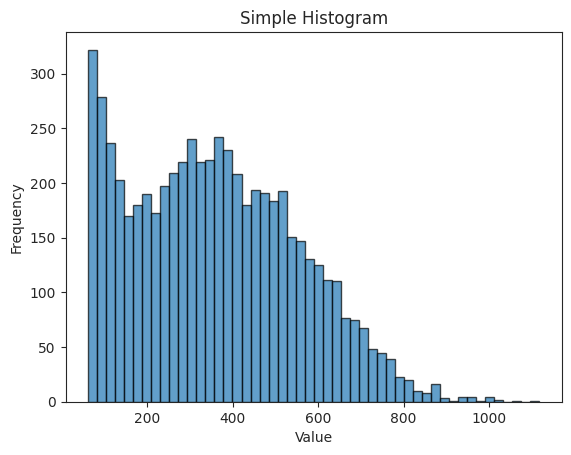

In [115]:
import matplotlib.pyplot as plt

# Sample data
data = [1, 1, 2, 3, 3, 3, 4, 4, 5, 6, 7, 8, 9, 10, 10]

# Plotting the histogram
plt.hist([i for k,i in enumerate(rowGeneExpression.values())], bins=50, edgecolor="k", alpha=0.7)

# Adding titles and labels
plt.title("Simple Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Displaying the plot
plt.show()

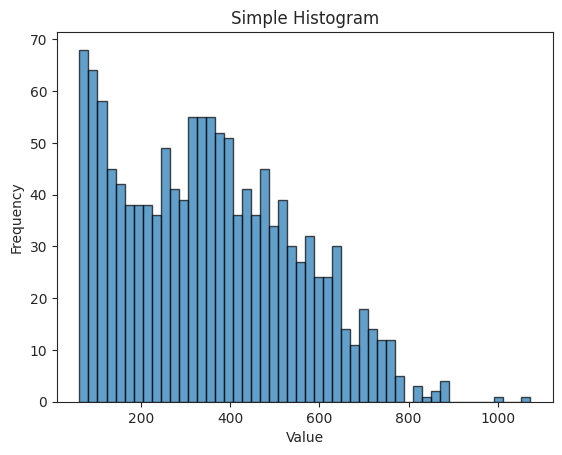

In [116]:
import matplotlib.pyplot as plt

# Sample data
data = [1, 1, 2, 3, 3, 3, 4, 4, 5, 6, 7, 8, 9, 10, 10]

# Plotting the histogram
plt.hist([i for k,i in enumerate(rowGeneExpression.values()) if not dependent_variables[k]], bins=50, edgecolor="k", alpha=0.7)

# Adding titles and labels
plt.title("Simple Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Displaying the plot
plt.show()

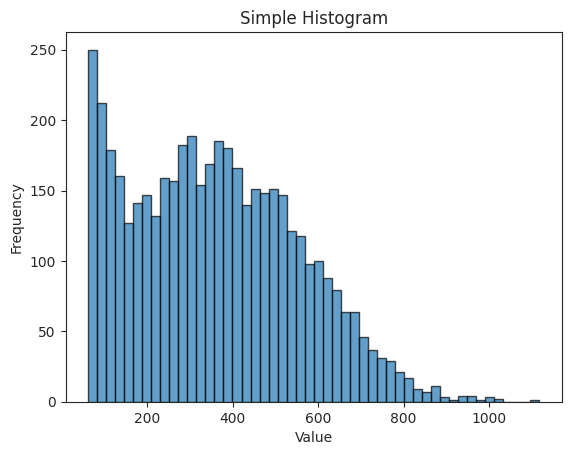

In [117]:
import matplotlib.pyplot as plt

# Sample data
data = [1, 1, 2, 3, 3, 3, 4, 4, 5, 6, 7, 8, 9, 10, 10]

# Plotting the histogram
plt.hist([i for k,i in enumerate(rowGeneExpression.values()) if dependent_variables[k]], bins=50, edgecolor="k", alpha=0.7)

# Adding titles and labels
plt.title("Simple Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Displaying the plot
plt.show()

2561

{'perturbation': tensor(-0.4119), 'perturbation_2': tensor(-0.0196), 'replicate': tensor(-0.4648), 'target': tensor(-0.2168), 'celltype': tensor(0.4469), 'cell_line': tensor(-0.1372), 'cancer': tensor(-0.4288), 'disease': tensor(0.3959), 'tissue_type': tensor(0.3873), 'organism': tensor(0.1284), 'perturbation_type': tensor(-0.0262), 'perturbation_type_2': tensor(-0.0658), 'ncounts': tensor(-0.0007), 'ngenes': tensor(0.1365), 'percent_mito': tensor(-0.3971), 'percent_ribo': tensor(-0.2806), 'nperts': tensor(-0.0731), 0: tensor(0.4723), 1: tensor(-0.2873), 2: tensor(0.4711), 3: tensor(-0.4946), 4: tensor(-0.1816), 5: tensor(-0.1965), 6: tensor(0.0498), 7: tensor(0.3828), 8: tensor(-0.3562), 9: tensor(-0.2500), 10: tensor(-0.3850), 11: tensor(-0.4825), 12: tensor(-0.2965), 13: tensor(0.2383), 14: tensor(0.2136), 15: tensor(0.1818), 16: tensor(-0.4992), 17: tensor(0.2236), 18: tensor(-0.3735), 19: tensor(0.4865), 20: tensor(-0.0047), 21: tensor(0.0144), 22: tensor(0.2591), 23: tensor(0.277

(4585, 1320)


In [37]:
predictions

[tensor(0.3495),
 tensor(0.5863),
 tensor(0.2866),
 tensor(0.2359),
 tensor(0.6634),
 tensor(0.3704),
 tensor(0.5501),
 tensor(0.5534),
 tensor(0.3529),
 tensor(0.5073),
 tensor(0.3327),
 tensor(0.5390),
 tensor(0.4167),
 tensor(0.6498),
 tensor(0.6255),
 tensor(0.4945),
 tensor(0.4674),
 tensor(0.3587),
 tensor(0.4538),
 tensor(0.6592),
 tensor(0.4458),
 tensor(0.5806),
 tensor(0.3192),
 tensor(0.5756),
 tensor(0.4492),
 tensor(0.5652),
 tensor(0.5781),
 tensor(0.3386),
 tensor(0.6452),
 tensor(0.5652),
 tensor(0.5532),
 tensor(0.4977),
 tensor(0.5411),
 tensor(0.6910),
 tensor(0.4187),
 tensor(0.5462),
 tensor(0.5241),
 tensor(0.5672),
 tensor(0.4400),
 tensor(0.4861),
 tensor(0.5285),
 tensor(0.6627),
 tensor(0.3450),
 tensor(0.4894),
 tensor(0.5715),
 tensor(0.5939),
 tensor(0.4246),
 tensor(0.5010),
 tensor(0.4952),
 tensor(0.5078),
 tensor(0.4333),
 tensor(0.3733),
 tensor(0.2720),
 tensor(0.6343),
 tensor(0.6134),
 tensor(0.5046),
 tensor(0.3825),
 tensor(0.4432),
 tensor(0.5408

In [7]:
import os
import pathlib

# print(pathlib.Path('yourPath.example').suffix) # '.example'
# print(pathlib.Path("hello/foo.bar.tar.gz").suffixes) # ['.bar', '.tar', '.gz']
# print(pathlib.Path('/foo/bar.txt').stem) # 'bar'

folders = '/home/awahab/llm-testing/data_sets/'
#fp = 'FrangiehIzar2021_RNA.h5ad' - control means probably works
fp = 'TianKampmann2021_CRISPRi.h5ad'
fp2 = 'TianKampmann2021_CRISPRa.h5ad'

#adata = sc.read_h5ad(folders + fp)

files = [fp for fp in os.listdir(folders) if pathlib.Path(fp).suffix == '.h5ad']


#print(files)
def runNNWithData(file_name):
    file_name = folders + file_name
    adata = sc.read_h5ad(file_name)
    print(file_name)
    #print(adata.obs.columns)
    t_dep, t_indep, trn_dep,val_dep,val_dep, val_indep, df = h5adToData(adata)
    runNN(t_dep, t_indep, trn_dep,val_dep,val_dep, val_indep, df)
    
#runNNWithData(fp2, files)
#for f in files[1:]: runNNWithData(f)

#runNNWithData(one)







# file_name = folders + 'DatlingerBock2017.h5ad'
# adata = sc.read_h5ad(file_name)
#print(adata.obs.columns)
#t_dep, t_indep, trn_dep,val_dep,val_dep, val_indep, df = h5adToData(adata)
#runNN(t_dep, t_indep, trn_dep,val_dep,val_dep, val_indep, df)


In [127]:
#numerical_values = df.select_dtypes(include=[int, float]).values.tolist()
adata.obs[adata.obs['perturbation'] == 'control']

,perturbation,perturbation_2,replicate,target,celltype,cell_line,cancer,disease,tissue_type,organism,perturbation_type,perturbation_type_2,ncounts,ngenes,percent_mito,percent_ribo,nperts,geneExpressionCount
cell_barcode,,,,,,,,,,,,,,,,,,
TACTTGACCCCN,control,stimulated,1,NaN,T cells,Jurkat cells,True,acute T cell leukemia,cell_line,human,CRISPR,TCR stimulation,8696.0,2722,0.287488,25.091997,1,0.07
ATCTAGATACNN,control,stimulated,1,NaN,T cells,Jurkat cells,True,acute T cell leukemia,cell_line,human,CRISPR,TCR stimulation,2465.0,1336,2.839756,22.150101,1,0.07
GCATCAGTAATN,control,stimulated,1,NaN,T cells,Jurkat cells,True,acute T cell leukemia,cell_line,human,CRISPR,TCR stimulation,6452.0,2775,5.393676,13.096714,1,0.07
GTCTAATGTCNN,control,stimulated,1,NaN,T cells,Jurkat cells,True,acute T cell leukemia,cell_line,human,CRISPR,TCR stimulation,4352.0,1927,10.133272,18.336397,1,0.07
CTCGAGACTTGG,control,stimulated,1,NaN,T cells,Jurkat cells,True,acute T cell leukemia,cell_line,human,CRISPR,TCR stimulation,7651.0,2641,6.835708,22.977388,1,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCCAAATCAAAT,control,unstimulated,5,NaN,T cells,Jurkat cells,True,acute T cell leukemia,cell_line,human,CRISPR,TCR stimulation,17433.0,4920,3.154936,14.386508,1,0.07
GTCATTATAGGC,control,unstimulated,5,NaN,T cells,Jurkat cells,True,acute T cell leukemia,cell_line,human,CRISPR,TCR stimulation,8000.0,3009,3.175000,14.575000,1,0.07
TTGTTTTAAAAN,control,unstimulated,5,NaN,T cells,Jurkat cells,True,acute T cell leukemia,cell_line,human,CRISPR,TCR stimulation,8947.0,3384,2.391863,17.525427,1,0.07


In [125]:
adata.obs[adata.obs['perturbation'] == 'control' or adata.obs['perturbation'] == 'ctrl ' or adata.obs['perturbation'] == '*']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [5]:
one ='ZhaoSims2021.h5ad'
adata = sc.read_h5ad(folders + one)



In [196]:
indep_columns

NameError: name 'indep_columns' is not defined

In [ ]:
# model = scgen.SCGEN(adata_t, n_hidden=800, n_latent=100, n_layers=2)
# mdata = pt.dt.papalexi_2021()
# for col in mdata.obs: print(col)
# sc.pp.normalize_total(mdata["rna"])
# sc.pp.log1p(mdata["rna"])
# sc.pp.highly_variable_genes(mdata["rna"], subset=True)
# mu.prot.pp.clr(mdata["adt"])
# sc.pp.pca(mdata["rna"])
# We calculate neighbors with the cosine distance similarly to the original Seurat implementation
# sc.pp.neighbors(mdata["rna"], metric="cosine")
# sc.tl.umap(mdata["rna"])
# sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])
# ms = pt.tl.Mixscape()

# ms.perturbation_signature(
#     mdata["rna"],
#     pert_key="perturbation",
#     control="NT",
#     split_by="replicate",
#     n_neighbors=20,
# )
# ms.mixscape(adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert")
# mdata["rna"].obs
# pt.pl.ms.perturbscore(
#     adata=mdata["rna"], labels="gene_target", target_gene="IFNGR2", color="orange"
# )

#adata.var
#preprocess
#batchcontrol
#clustering
#cell type annotation
#embedding
#reverse transcriptome
#differential expression
# pt.pl.ms.heatmap(
#     adata=mdata["rna"],
#     labels="gene_target",
#     target_gene="IFNGR2",
#     layer="X_pert",
#     control="NT",
# )
import scgen
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)

#  are very local features enough or do we need global context? How much variation is there and what form does it take? What variation is spurious and could be preprocessed out? Does spatial position matter or do we want to average pool it out? How much does detail matter and how far could we afford to downsample the images? How noisy are the labels?


# https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02605-1

# adata_t = adata[
#     ~(
#         (adata.obs["cell_type"] == "CD4 T cells")
#         & (adata.obs["condition"] == "stimulated")
#     )
# ].copy()

# cd4t_stim = adata[
#     (
#         (adata.obs["cell_type"] == "CD4 T cells")
#         & (adata.obs["condition"] == "stimulated")
#     )
# ].copy()





# pred.obs

# train = adata
# ctrl_adata = adata[
#     ((adata.obs["cell_type"] == "CD4 T cells") & (adata.obs["condition"] == "control"))
# ]
# stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]

# # concatenate pred, control and real CD4 T cells in to one object
# eval_adata = ctrl_adata.concatenate(cd4t_stim, pred)
# sc.tl.pca(eval_adata)
# sc.pl.pca(eval_adata, color="condition", frameon=False)
# cd4t_adata = adata[adata.obs["cell_type"] == "CD4 T cells"]
# sc.tl.rank_genes_groups(cd4t_adata, groupby="condition", method="wilcoxon")
# diff_genes = cd4t_adata.uns["rank_genes_groups"]["names"]["stimulated"]
# diff_genes
# pred, delta = model.predict(
#     ctrl_key="control", stim_key="stimulated", celltype_to_predict="CD4 T cells"
# )

# # we annotate the predicted cells to distinguish them later from ground truth cells.
# pred.obs["condition"] = "prediction"
# print(pred)
# sc.pp.neighbors(adata_t, use_rep="scgen")
# sc.tl.umap(adata)
# adata_t.obsm["scgen"] = model.get_latent_representation()
# model.train(
#     max_epochs=1, batch_size=32, early_stopping=True, early_stopping_patience=25
# )


# scgen.SCGEN.setup_anndata(adata_t, batch_key="condition", labels_key="cell_type")



# mdata["adt"].obs["mixscape_class_global"] = mdata["rna"].obs["mixscape_class_global"]
# pt.pl.ms.violin(
#     adata=mdata["adt"],
#     target_gene_idents=["NT", "JAK2", "STAT1", "IFNGR1", "IFNGR2", "IRF1"],
#     keys="PDL1",
#     groupby="gene_target",
#     hue="mixscape_class_global",
# )
# sc.settings.set_figure_params(figsize=(10, 10))
# pt.pl.ms.violin(
#     adata=mdata["rna"],
#     target_gene_idents=["NT", "IFNGR2 NP", "IFNGR2 KO"],
#     groupby="mixscape_class",
# )
#rna velocity -> predicts the future state 
#predict the probability of unseen perturbations
#test: first data set => output list of perturbations 
# take a 2nd dataset and get list of perturbations + their probability 
# ms.lda(adata=mdata["rna"], labels="gene_target", layer="X_pert")

#representation learning (in particular, self-supervised, multi-view, and transfer learning
#https://registry.opendata.aws/tabula-muris/#usageexamples

#see what preprocessing is needed to get better accuracy

##load data

##import premade model => output list of predicted unseen perturbation
#sc.pp.calculate_qc_metrics(adata)

#write custom model. get better accuracy

#https://www.10xgenomics.com/resources/datasets/10-k-a-375-cells-transduced-with-1-non-target-and-1-target-sg-rna-dual-indexed-3-1-standard-4-0-0
# !pip install --quiet hyperopt
# !pip install --quiet "ray[tune]"
# !pip install --quiet scvi-colab
# from scvi_colab import install

# install()


# import ray
# import scanpy as sc
# import scvi
# from ray import tune
# from scvi import autotune
# model_cls = scvi.model.SCVI
# model_cls.setup_anndata(adata)
# scvi_tuner = autotune.ModelTuner(model_cls)


# # pt.pl.ms.lda(adata=mdata["rna"])
# #https://zenodo.org/record/7058382
# 
# fp1 = 'SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_raw_molecule_info.h5'
# fp2 = 'SC3_v3_NextGem_DI_CRISPR_A549_5K_Multiplex_count_raw_molecule_info.h5'


# import h5py
# import anndata

# # Read the .h5 File
# def explore_h5py_group(group, indent=0):
#     """Recursively print the contents of an h5py group/dataset."""
#     #print(group.data.name)
#     items = sorted(group.items())
#     for name, item in items:
#         if isinstance(item, h5py.Dataset):  # Check if item is a dataset
#             print("  " * indent + f"Dataset: {name} (Shape: {item.shape}, Dtype: {item.dtype})")
#         elif isinstance(item, h5py.Group):  # Check if item is a group
#             print("  " * indent + f"Group: {name}")
#             explore_h5py_group(item, indent + 1)  # Recursive call to explore subgroups

# # Open your HDF5 file
# with h5py.File(folders + fp2, 'r') as f:
#     explore_h5py_group(f)
    
# #hv_genes = filtered_keys = df[df['column_name'] == True].index.tolist()

# #normal_genes = filtered_keys = df[df['column_name'] == False].index.tolist()
# #https://karpathy.github.io/2019/04/25/recipe/
# #https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b
# #check bookmarks
# #https://www.youtube.com/watch?v=qlLChbHhbg4&ab_channel=AndrejKarpathy
# #print(hv_genes, normal_genes)
# #https://github.com/karpathy/nn-zero-to-hero

# # import numpy as np
# # import matplotlib.pyplot as plt
# # %matplotlib inline


# # plt.hist(hv_columns, bins=30, edgecolor="k")  # `bins` determines the number of bins/bars.
# # plt.title("Histogram of Data")
# # plt.xlabel("Value")
# # plt.ylabel("Frequency")
# # plt.show()
# http://projects.sanderlab.org/pertbio/
#https://nbisweden.github.io/workshop-scRNAseq/

# We create a copy of the object to recalculate the PCA.
# Alternatively we could replace the X of the RNA part of our MuData object with the `X_pert` layer.
# adata_pert = mdata["rna"].copy()
# adata_pert.X = adata_pert.layers["X_pert"]
# sc.pp.pca(adata_pert)
# sc.pp.neighbors(adata_pert, metric="cosine")
# sc.tl.umap(adata_pert)
# sc.pl.umap(adata_pert, color=["replicate", "Phase", "perturbation"])

# r2_value = model.reg_mean_plot(
#     eval_adata,
#     axis_keys={"x": "predicted stimulated", "y": "stimulated"},
#     gene_list=diff_genes[:10],
#     top_100_genes=diff_genes,
#     labels={"x": "predicted", "y": "ground truth"},
#     show=True,
#     legend=False,
# )
# import pertpy as pt
# import muon as mu
# import scanpy as sc
# sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

In [194]:
url = [
#     "https://zenodo.org/record/7416068/files/AdamsonWeissman2016_GSM2406675_10X001.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/AdamsonWeissman2016_GSM2406677_10X005.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/AdamsonWeissman2016_GSM2406681_10X010.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/AissaBenevolenskaya2021.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/ChangYe2021.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/DatlingerBock2017.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/DatlingerBock2021.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/DixitRegev2016.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/FrangiehIzar2021_protein.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/FrangiehIzar2021_RNA.h5ad?download=1",
#     "https://zenodo.org/record/7416068/files/GasperiniShendure2019_atscale.h5ad?download=1",
    
    "https://zenodo.org/record/7416068/files/GasperiniShendure2019_highMOI.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/GasperiniShendure2019_lowMOI.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/GehringPachter2019.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/McFarlandTsherniak2020.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/NormanWeissman2019_filtered.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_arrayed_protein.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_arrayed_RNA.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_protein.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/PapalexiSatija2021_eccite_RNA.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ReplogleWeissman2022_K562_essential.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ReplogleWeissman2022_K562_gwps.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ReplogleWeissman2022_rpe1.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SchiebingerLander2019_GSE106340.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SchiebingerLander2019_GSE115943.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ShifrutMarson2018.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SrivatsanTrapnell2020_sciplex2.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SrivatsanTrapnell2020_sciplex3.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/SrivatsanTrapnell2020_sciplex4.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/TianKampmann2019_day7neuron.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/TianKampmann2019_iPSC.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/TianKampmann2021_CRISPRa.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/TianKampmann2021_CRISPRi.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/WeinrebKlein2020.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/XieHon2017.h5ad?download=1",
    "https://zenodo.org/record/7416068/files/ZhaoSims2021.h5ad?download=1"
]

import requests
 
def download_url(url):
  print("downloading: ",url)
  # assumes that the last segment after the / represents the file name
  # if url is abc/xyz/file.txt, the file name will be file.txt
  file_name_start_pos = url.rfind("/") + 1
  file_name = url[file_name_start_pos:]
 
  r = requests.get(url, stream=True)
  if r.status_code == requests.codes.ok:
    with open(file_name, 'wb') as f:
      for data in r:
        f.write(data)

#for link in url: download_url(link)
    #https://zenodo.org/record/7058382
    
#find data set with some perturbed and some not
#train on a half with some of both 
#apply to other half and see if predictions are true


import requests
from multiprocessing.pool import ThreadPool

def download_url(url):
  print("downloading: ",url)
  # assumes that the last segment after the / represents the file name
  # if url is abc/xyz/file.txt, the file name will be file.txt
  file_name_start_pos = url.rfind("/") + 1
  file_name = url[file_name_start_pos:]

  r = requests.get(url, stream=True)
  if r.status_code == requests.codes.ok:
    with open(file_name, 'wb') as f:
      for data in r:
        f.write(data)
  return url

# results = ThreadPool(5).imap_unordered(download_url, url)
# for r in results:
#     print(r)

downloading:  https://zenodo.org/record/7416068/files/GasperiniShendure2019_highMOI.h5ad?download=1


KeyboardInterrupt: 

In [195]:
# ! pip install aiohttp
# ! pip install aiofile
import os
import asyncio
import aiohttp  # pip install aiohttp
import aiofile  # pip install aiofile


FILES_PATH = url


def download_files_from_report(urls):
    sema = asyncio.BoundedSemaphore(5)

    async def fetch_file(session, url):
        fname = url.split("/")[-1]
        async with sema:
            async with session.get(url) as resp:
                assert resp.status == 200
                data = await resp.read()

        async with aiofile.async_open(
            os.path.join(FILES_PATH, fname), "wb"
        ) as outfile:
            await outfile.write(data)

    async def main():
        async with aiohttp.ClientSession() as session:
            tasks = [fetch_file(session, url) for url in urls]
            await asyncio.gather(*tasks)

    loop = asyncio.get_event_loop()
    loop.run_until_complete(main())
    loop.close()
for fp in FILES_PATH: download_files_from_report(fp)

RuntimeError: This event loop is already running

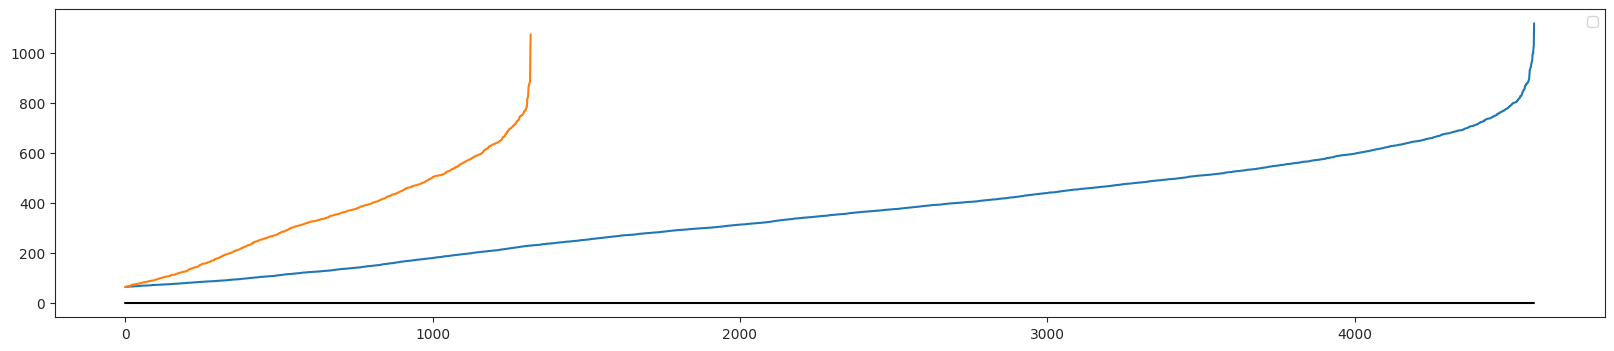

In [138]:
#https://zenodo.org/record/7058382
#http://projects.sanderlab.org/scperturb/datavzrd/scPerturb_vzrd_v1/dataset_info/index_1.html
#https://nbisweden.github.io/workshop-scRNAseq/
#https://github.com/fastai/course22p2/blob/master/nbs/15_DDPM.ipynb

#plt.hist(, bins=50, edgecolor="k", alpha=0.7)

plt.figure(figsize=(20, 4))
legends = []

blue = [i for k,i in enumerate(rowGeneExpression.values()) if dependent_variables[k]]
oj =[i for k,i in enumerate(rowGeneExpression.values()) if not dependent_variables[k]]
blue.sort()
oj.sort()
plt.plot((blue)) #blue true peturbation 
plt.plot(oj) #orange false ctrl

#legends.append('param %d' % i)
plt.plot([0, len([i for k,i in enumerate(rowGeneExpression.values()) if dependent_variables[k]])], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
#https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02021-3